Part (a) - Simple Linear Regression
UE23CS342AA2 - Data Analytics

There are 2 questions in this worksheet.

Pranav Rao P - pranavraop2023@gmail.com

Name:Rithvik Rajesh Matta

SRN:PES2UG23CS485

Sec:H

## Solar Power Prediction

Your task is to analyse a Solar plant dataset to uncover the factors that influence DC power output. By examining various predictors and their impact on DC power, you can provide actionable insights that help operators optimise production and improve forecasting accuracy.



**Dataset Overview**

This data has been gathered at a solar power plant in India over a 34-day period, covering the time range from 6:00 AM to 6:00 PM each day. Sometimes during the day, even when solar irradiation is clearly present, the corresponding DC power output is observed to be exactly zero, indicating possible defects or sensor issues. Conversely, power may be non-zero even when irradiation is nearly absent, suggesting data logging delays or inconsistencies.

Let's have a look at the dataset consisting of around 70,000 records and it's different columns.

Variables:
* IRRADIATION: The amount of solar energy received per square meter at the plant. 
* MODULE_TEMPERATURE: The temperature of the photovoltaic (PV) panels in degrees Celsius.
* AMBIENT_TEMPERATURE: The air temperature around the solar panels in degrees Celsius.
* DAILY_YIELD: The total energy (in kilowatt-hours) generated by the plant since midnight.
* TOTAL_YIELD: The cumulative energy (in kilowatt-hours) produced by the plant over its lifetime.
* AC_POWER: The alternating current (AC) power output from the inverter (in watts).

Target Variable
* DC_POWER (kW) – The instantaneous electrical power generated on the DC side of the inverters.


In [3]:
options(warn = -1) 

library(tidyverse)
library(lubridate)
library(reshape2)
library(ggplot2)
library(scales)
library(caret)
library(ggplot2)
library(car)      

### Data Visualisation

In [4]:
df <- read_csv("/kaggle/input/worksheet-2-slr/Solar_plant.csv" , show_col_types = FALSE)
cat("Rows:", nrow(df), "| Columns:", ncol(df), "\n\n")
head(df)

Rows: 68774 | Columns: 9 



DATE_TIME,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
15-05-2020 00:00,1BY6WEcLGh8j5v7,3058.867,4464.3028,0,6259559,25.18432,29.96321,0.8778627
15-05-2020 00:00,1IF53ai7Xc0U56Y,7610.643,6460.9439,0,6183645,25.18432,76.05714,0.9571136
15-05-2020 00:00,3PZuoBAID5Wc2HD,5882.752,6516.0787,0,6987759,25.18432,58.55952,0.4014522
15-05-2020 00:00,7JYdWkrLSPkdwr4,4829.402,4683.3235,0,7602960,25.18432,47.89268,0.7513365
15-05-2020 00:00,McdE0feGgRqW7Ca,1332.547,153.5045,0,7158964,25.18432,12.48149,0.2225238
15-05-2020 00:00,VHMLBKoKgIrUVDU,1332.357,820.4374,0,7206408,25.18432,12.47956,0.9512518


In [5]:
glimpse(df)

Rows: 68,774
Columns: 9
$ DATE_TIME           <chr> "15-05-2020 00:00", "15-05-2020 00:00", "15-05-202…
$ SOURCE_KEY          <chr> "1BY6WEcLGh8j5v7", "1IF53ai7Xc0U56Y", "3PZuoBAID5W…
$ DC_POWER            <dbl> 3058.8669, 7610.6430, 5882.7521, 4829.4020, 1332.5…
$ AC_POWER            <dbl> 4464.3028, 6460.9439, 6516.0787, 4683.3235, 153.50…
$ DAILY_YIELD         <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ TOTAL_YIELD         <dbl> 6259559, 6183645, 6987759, 7602960, 7158964, 72064…
$ AMBIENT_TEMPERATURE <dbl> 25.18432, 25.18432, 25.18432, 25.18432, 25.18432, …
$ MODULE_TEMPERATURE  <dbl> 29.963210, 76.057145, 58.559515, 47.892679, 12.481…
$ IRRADIATION         <dbl> 0.8778627, 0.9571136, 0.4014522, 0.7513365, 0.2225…


**1)** Design a preprocessing pipeline to clean solar power data to make it fit for predictive modelling. (hint: clearly read the Dataset overview section.)  (2 marks.)

In [6]:
# ---- Preprocessing Pipeline ----

# Convert DATE_TIME to proper datetime format
df <- df %>%
  mutate(DATE_TIME = dmy_hm(DATE_TIME))

# Remove duplicate rows (if any)
df <- df %>% distinct()

# Handle missing values
# (check how many NAs are present in each column)
colSums(is.na(df))

# Remove rows with NA values (or impute if needed)
df <- df %>% drop_na()

# Remove inconsistent records:
# 1. DC_POWER = 0 when IRRADIATION > 0  → faulty readings
# 2. DC_POWER > 0 when IRRADIATION ≈ 0 → logging delays
df <- df %>%
  filter(!(DC_POWER == 0 & IRRADIATION > 0)) %>%
  filter(!(DC_POWER > 0 & IRRADIATION == 0))

# Remove extreme outliers (if DC_POWER < 0 or IRRADIATION < 0)
df <- df %>%
  filter(DC_POWER >= 0, IRRADIATION >= 0)

# Feature engineering (optional):
# Add hour, day, month for temporal effects
df <- df %>%
  mutate(HOUR = hour(DATE_TIME),
         DAY = day(DATE_TIME),
         MONTH = month(DATE_TIME))

# Reset row indices
df <- df %>% arrange(DATE_TIME)

cat("Cleaned Rows:", nrow(df), "\n")
glimpse(df)


DATE_TIME          SOURCE_KEY            DC_POWER            AC_POWER 
                  0                   0                   0                   0 
        DAILY_YIELD         TOTAL_YIELD AMBIENT_TEMPERATURE  MODULE_TEMPERATURE 
                  0                   0                   0                   0 
        IRRADIATION 
                  0

Cleaned Rows: 67221 
Rows: 67,221
Columns: 12
$ DATE_TIME           <dttm> 2020-05-15 00:00:00, 2020-05-15 00:00:00, 2020-05…
$ SOURCE_KEY          <chr> "1BY6WEcLGh8j5v7", "1IF53ai7Xc0U56Y", "3PZuoBAID5W…
$ DC_POWER            <dbl> 3058.8669, 7610.6430, 5882.7521, 4829.4020, 1332.5…
$ AC_POWER            <dbl> 4464.3028, 6460.9439, 6516.0787, 4683.3235, 153.50…
$ DAILY_YIELD         <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ TOTAL_YIELD         <dbl> 6259559, 6183645, 6987759, 7602960, 7158964, 72064…
$ AMBIENT_TEMPERATURE <dbl> 25.18432, 25.18432, 25.18432, 25.18432, 25.18432, …
$ MODULE_TEMPERATURE  <dbl> 29.963210, 76.057145, 58.559515, 47.892679, 12.481…
$ IRRADIATION         <dbl> 0.8778627, 0.9571136, 0.4014522, 0.7513365, 0.2225…
$ HOUR                <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ DAY                 <int> 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15…
$ MONTH               <dbl> 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5

**2)** How would you compute, rank, and visually display the correlations to identify the single best predictor for modeling DC_POWER with simple linear regression?


Correlation with DC_POWER (AC_POWER excluded):
AMBIENT_TEMPERATURE         IRRADIATION  MODULE_TEMPERATURE         DAILY_YIELD 
              0.492               0.475               0.346               0.037 
                DAY                HOUR         TOTAL_YIELD               MONTH 
              0.025               0.004               0.003              -0.032 


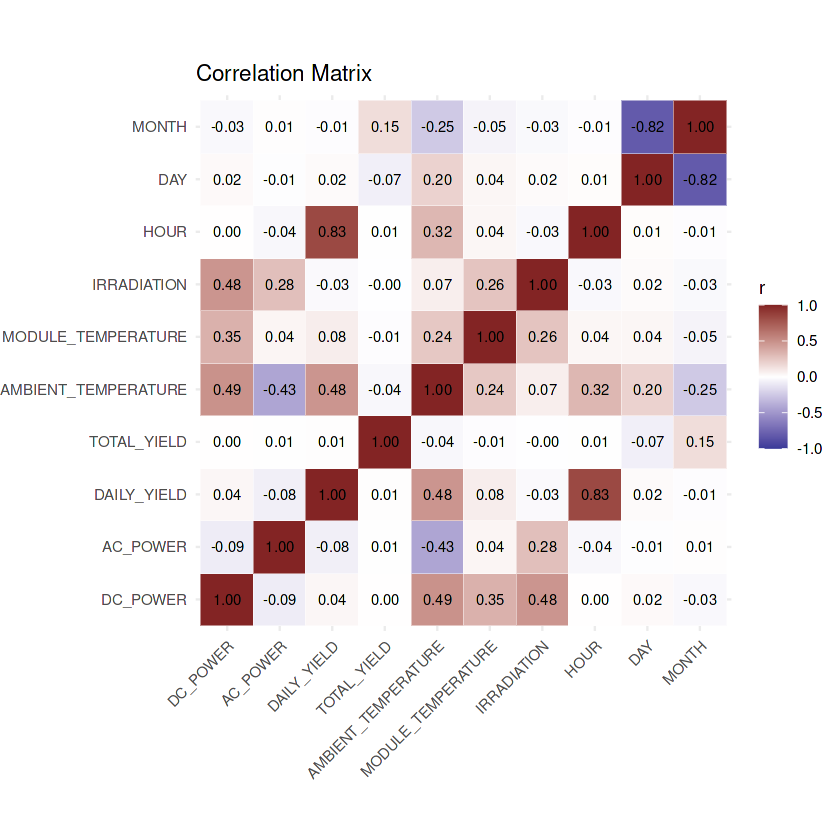

In [7]:
num_cols <- names(df)[sapply(df, is.numeric)]
corr_matrix <- cor(df[num_cols], use = "pairwise.complete.obs")

corr_series <- corr_matrix[, "DC_POWER"][-which(names(corr_matrix[, "DC_POWER"]) == "DC_POWER")]
corr_noAC   <- corr_series[names(corr_series) != "AC_POWER"]

corr_sorted <- sort(corr_noAC, decreasing = TRUE)
cat("\nCorrelation with DC_POWER (AC_POWER excluded):\n")
print(round(corr_sorted, 3))

corr_melt <- melt(corr_matrix)

ggplot(corr_melt, aes(Var1, Var2, fill = value)) +
  geom_tile(color = "white") +
  scale_fill_gradient2(low  = muted("blue"),
                       mid  = "white",
                       high = muted("red"),
                       midpoint = 0,
                       limits   = c(-1, 1)) +
  coord_equal() +
  geom_text(aes(label = sprintf("%.2f", value)), size = 3) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(title = "Correlation Matrix",
       x = NULL, y = NULL, fill = "r")

**3)** Which predictor was chosen??

In [8]:
top_feat <- names(corr_sorted)[1]
cat(sprintf("\nChosen predictor: %s  (r = %.3f)\n", top_feat, corr_sorted[top_feat]))



Chosen predictor: AMBIENT_TEMPERATURE  (r = 0.492)


### Regression

Regression is a core statistical method to fit the relationship between variables, enabling us to see the impact of changes in one variable on another. It is of immense importance in predicting the outcomes, the discovery of patterns, and facilitation of data-driven decision-making in numerous applications.

**1)** Write code to split your dataset into training test set using the highest‑correlated predictor and the target variable.

In [9]:
X <- df[top_feat]
y <- df$DC_POWER

set.seed(42)

train_idx <- sample(seq_len(nrow(df)), size = 0.75 * nrow(df))

X_train <- X[train_idx, , drop = FALSE]
y_train <- y[train_idx]
train_df  <- df[train_idx, ]

X_test  <- X[-train_idx, , drop = FALSE]
y_test  <- y[-train_idx]
test_df   <- df[-train_idx, ]

cat("Train size:", nrow(X_train), "| Test size:", nrow(X_test), "\n")

Train size: 50415 | Test size: 16806 


**2)** How would you construct and evaluate a simple linear regression model??

In [10]:
fmla <- as.formula(paste("DC_POWER ~", top_feat))
slr <- lm(fmla, data = df)
summary(slr)


Call:
lm(formula = fmla, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-7832.9 -2234.0     7.5  2259.3  8360.6 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)         -7376.93      85.45  -86.33   <2e-16 ***
AMBIENT_TEMPERATURE   485.62       3.31  146.69   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2893 on 67219 degrees of freedom
Multiple R-squared:  0.2425,	Adjusted R-squared:  0.2425 
F-statistic: 2.152e+04 on 1 and 67219 DF,  p-value: < 2.2e-16


**3)** Assess the performance of the fitted SLR model on both training and test data using R² and RMSE.

In [11]:

train_pred <- predict(slr, newdata = train_df)
test_pred  <- predict(slr, newdata  = test_df)

## 5. Metrics
train_met <- caret::postResample(train_pred, train_df$DC_POWER)
test_met  <- caret::postResample(test_pred,  test_df$DC_POWER)

cat(sprintf("Train  R²: %.3f | RMSE: %.0f\n", train_met["Rsquared"], train_met["RMSE"]))
cat(sprintf("Test   R²: %.3f | RMSE: %.0f\n",  test_met["Rsquared"],  test_met["RMSE"]))


Train  R²: 0.244 | RMSE: 2893
Test   R²: 0.239 | RMSE: 2893


**4)**  
a)Create a full set of diagnostic visuals for your SLR model. 

b) Give your thoughts about the visual representations. Does your model violate any OLS assumptions? (1 point.)

`geom_smooth()` using formula = 'y ~ x'


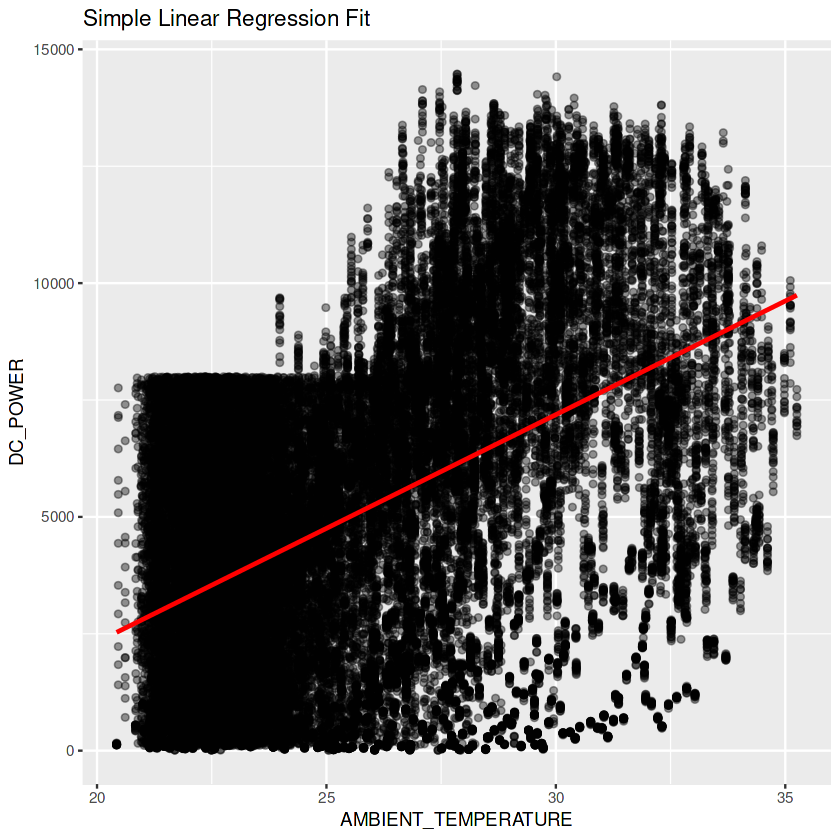

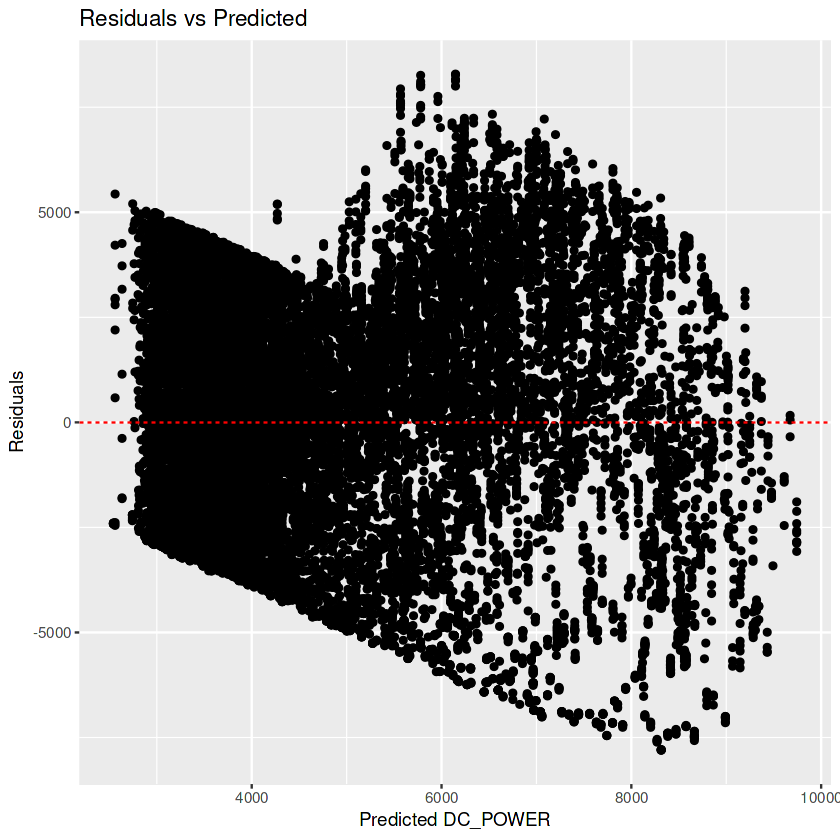

[1] 15086 15083

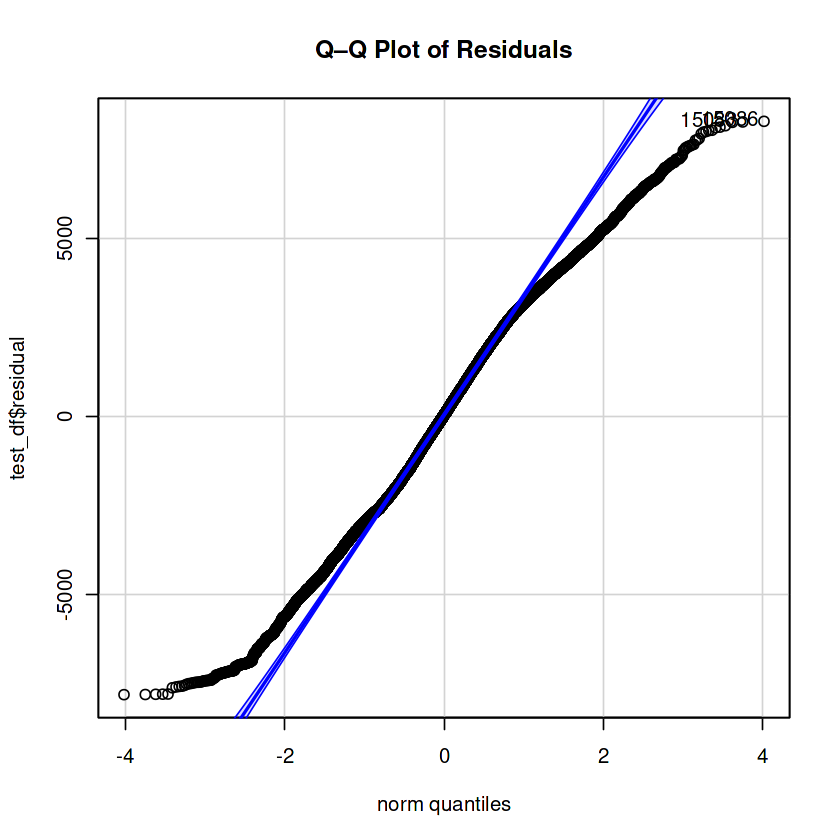

In [12]:
ggplot(train_df, aes_string(x = top_feat, y = "DC_POWER")) +
  geom_point(alpha = 0.4) +
  geom_smooth(method = "lm", se = FALSE, colour = "red") +
  labs(
    title = "Simple Linear Regression Fit",
    x = top_feat,
    y = "DC_POWER"
  )


test_df$predicted <- test_pred
test_df$residual  <- test_df$DC_POWER - test_df$predicted

ggplot(test_df, aes(predicted, residual)) +
  geom_point() +
  geom_hline(yintercept = 0, colour = "red", linetype = "dashed") +
  labs(
    title = "Residuals vs Predicted",
    x = "Predicted DC_POWER",
    y = "Residuals"
  )


qqPlot(test_df$residual, main = "Q–Q Plot of Residuals")



* From the scatter plot with the regression line, there is a positive trend but the points are highly scattered, showing a weak linear fit.
* The residuals vs. predicted plot shows a funnel shape, indicating heteroscedasticity (violation of constant variance).
* The Q–Q plot shows deviations at the tails, suggesting that residuals are not perfectly normal.
* Thus, the model violates the OLS assumptions of constant variance and normality of errors, while linearity is only weakly satisfied.
